## Basic network properties across connectomes 
We analyze the basic network properties of the connectomes of:

* C. elegans (last stage) of *Witvliet et al:* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8756380/  
* Drosophila larva of *Winding et al., 2023* https://www.science.org/doi/10.1126/science.add9330 
* MICrONS data set of the *IARPA MICrONS mm^3 dataset* https://www.microns-explorer.org/cortical-mm3 

And compare them with 
* The V5 version of the Blue Brain Project model of https://www.cell.com/fulltext/S0092-8674(15)01191-5

For easy handling, we use the the conntility package and the code provided in 
https://github.com/BlueBrain/ConnectomeUtilities/blob/main/examples
for loading the three first connectivity matrices 

In [1]:
import pickle 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
import sys 
sys.path.append('../../../library')
from structural_basic import load_connectome

In [2]:
# Load pre-computed simplex counts 
root="/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data"
connectomes=["Celegans", "Drosophila", "MICrONS","BBP"]
sc, rc ={}, {}
for conn in connectomes:
    with open(f"{root}/{conn}_simplex_counts_.pkl", "rb") as f:
        sc[conn]=pickle.load(f)
    with open(f"{root}/{conn}_count_rc_edges_skeleta_.pkl", "rb") as f:
        rc[conn]=pickle.load(f)
rc_den={}
for conn in connectomes:
    with open(f"{root}/{conn}_rc_densities.pkl", "rb") as f:
        rc_den[conn]=pickle.load(f)

In [3]:
# Font sizes and color schemes and labels
titlesize=8
labelsize=6
ticksize=6
marker_size=2
conversion=2.54
#conversion=1.5


cmap=plt.cm.Dark2
colors={
    'original':'indianred',#cmap(3), 
    'configuration_model':cmap(2), 
    'ER_shuffle':cmap(0), 
    'underlying_model':cmap(4), 
    'bishuffled_model':cmap(5), 
    'run_DD2':cmap(1)}
legend={
    'original':"Original", 
    'configuration_model':"CM", 
    'ER_shuffle':"ER", 
    'underlying_model':"Underlying", 
    'bishuffled_model':"Shuffle", 
    'run_DD2':"Distance"}
markers={
    'original':"o", 
    'configuration_model':"P", 
    'ER_shuffle':"*", 
    'underlying_model':"*", 
    'bishuffled_model':"*", 
    'run_DD2':"H"}

In [4]:
# Plotting functions 
def plot_control(ax, df, key, alpha=0.25, linestyle=None, marker=None,linewidth=None):
    df_mean=df.mean(axis=1).astype(float) 
    err=df.apply(stats.sem,axis=1).to_numpy().astype(float)
    ax.plot(df_mean.index, df_mean, color=colors[key], marker=marker, ms=marker_size,linestyle=linestyle, linewidth=linewidth)
    bottom=df_mean.to_numpy()-err
    top=df_mean.to_numpy()+err
    ax.fill_between(df_mean.index.to_numpy(), bottom, top, alpha=alpha, color=colors[key])

def plot_binary_matrix(N,color,ax):
    from matplotlib import colors as col
    cmap = col.ListedColormap(['none', color])
    bounds=[0,0.5,1]
    norm = col.BoundaryNorm(bounds, cmap.N)
    img = ax.imshow(N, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)
    valmin=0
    n=N.shape[0]
    ax.set_xlim([0,n])
    ax.set_ylim([0,n])
    ax.spines[:].set_color("lightgray")
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def plot_sc_inset(ax, conn, log=True):
    if log:
        ax.set_yscale('log')
    ctr="original"
    ax.plot(sc[conn][ctr], color=colors[ctr], marker=None, linewidth=1)
    ax.set_xticks([sc[conn][ctr].index.min(), sc[conn][ctr].index.max()])
    ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=ticksize)
    ax.minorticks_off()
    for ctr in ['underlying_model','bishuffled_model']:
        df=pd.DataFrame.from_dict(sc[conn][ctr]).fillna(0).astype(int)
        plot_control(ax,df,ctr,alpha=0.5,marker=None, linewidth=0.5, linestyle='dotted')
        ax.spines[["right", "top"]].set_visible(False)    
def plot_rc_violin(ax, conns):
    # Aggreate all into single DataFrame 
    df=[]
    for conn in conns:
        temp=np.reciprocal(pd.DataFrame.from_dict({key:rc_den[conn][key] for key in rc_den[conn] if key!='original'})/
                           rc_den[conn]['original'])
        df.append(temp.rename(columns=legend))
    df=pd.concat(df, axis=1, keys=connectomes)
    # Color dict in seaborn format 
    palette={(conn,legend[ctr]):colors[ctr] for conn in connectomes for ctr in colors.keys()}
    sns.violinplot(df, ax=ax, palette=palette, saturation=0.5, inner=None, linewidth=0)
    ax.set_xticks(range(len(df.columns)), labels=df.columns.get_level_values(level=1))
    ax.tick_params(axis='both', labelsize=labelsize)
    #ax.spines[["right", "bottom"]].set_visible(False)
    ax.spines[:].set_visible(False)
    #ax.xaxis.tick_top()
    
def plot_rc_bar(ax, conns):
    # Aggreate all into single DataFrame 
    df=[]
    for conn in conns:
        temp=np.reciprocal(pd.DataFrame.from_dict({key:rc_den[conn][key] for key in rc_den[conn] if key!='original'})/
                           rc_den[conn]['original'])
        df.append(temp)
    df=pd.concat(df, axis=1, keys=connectomes)
    heights=df.mean(axis=0)
    yerr=df.apply(np.std, axis=0)
    labels=[legend[key] for key in heights.index.get_level_values(level=1)]
    c=[colors[key] for key in heights.index.get_level_values(level=1)]
    ax.bar(x=range(len(heights)), height=heights.to_numpy(), yerr=yerr, color=c)
    ax.set_yticks(np.linspace(1,7, 3))
    ax.spines[:].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(axis='both', labelsize=labelsize)
    ax.set_xticks([])
    #ax.set_xticks(range(len(heights)),labels, rotation=45)
    #ax.legend(ax.patches[0:3], labels[0:3], frameon=False, fontsize=labelsize)
    ax.legend(ax.patches[-3:], labels[-3:], frameon=False, fontsize=labelsize)



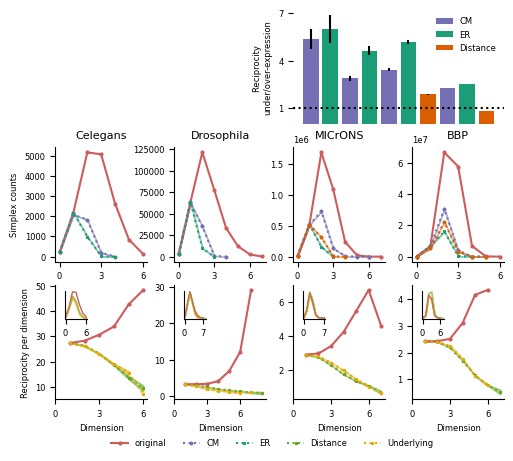

In [5]:
# OPTION 1
width=21*0.7/conversion
mosaic = [['.', '.', 'rc_den','rc_den'],
            ['sc_a', 'sc_b','sc_c', 'sc_d'],
           ['rc_a', 'rc_b','rc_c', 'rc_d']]
fig, axes =plt.subplot_mosaic(mosaic,figsize=(width, width*3.5/4))

# Reciprocal density
plot_rc_bar(axes['rc_den'], connectomes)
axes['rc_den'].axline((0,1), slope=0, linestyle="dotted", color="black")
axes['rc_den'].set_ylabel("Reciprocity \nunder/over-expression", fontsize=labelsize)

axs=np.array([axes[key] for key in list(axes.keys())[1:]]).reshape(2,4)# For easy handling
for j, conn in enumerate(connectomes): 
    axs[0, j].set_title(conn, fontsize=titlesize)
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.spines[["top", "right"]].set_visible(False)
labels=['original']
for j, conn in enumerate(connectomes): 
    # Simplex counts 
    i=0
    axs[i,0].set_ylabel("Simplex counts", fontsize=labelsize)
    for ctr in sc[conn].keys():
        #axs[i,j].set_yscale('log')
        if ctr=='original':
            axs[i,j].plot(sc[conn][ctr], color=colors[ctr], marker=markers[ctr],ms=marker_size)
        elif (ctr!='underlying_model') and (ctr!='bishuffled_model'):
            if conn=='MICrONS': labels+=[legend[ctr]]
            df=pd.DataFrame.from_dict(sc[conn][ctr]).fillna(0).astype(int)
            plot_control(axs[i,j],df,ctr,alpha=0.5, linestyle="dotted", marker=markers[ctr])
        axs[i,j].minorticks_off()

    # Reciprocal connections
    i=1
    axs[i,0].set_ylabel("Reciprocity per dimension", fontsize=labelsize)
    for ctr in rc[conn].keys():
        axs[i,j].set_xlabel('Dimension', fontsize=labelsize)
        if ctr=='original':
            axs[i,j].plot(rc[conn][ctr].index, rc[conn][ctr]['rc/edges_percent'],
                          marker=markers[ctr],ms=marker_size, color=colors[ctr])
        else:
            if conn=='MICrONS': labels+=[legend[ctr]]
            df=pd.DataFrame.from_dict({key:rc[conn][ctr][key]['rc/edges_percent'] for key in rc[conn][ctr]})
            plot_control(axs[i,j],df, ctr, alpha=0.5, linestyle="dotted", marker=markers[ctr])
    x0, y0, width, height=0.1, 0.7, 0.25, 0.25
    ax=axs[i,j].inset_axes([x0, y0, width, height])
    plot_sc_inset(ax, conn, log=False)


        
# Adding legend
# Get lines 
h1=axs[0,1].get_lines(); h2=axs[1,1].get_lines()[1:]
fig.legend(handles=h1+h2, labels=labels, frameon=False, ncols=6, loc=8, bbox_to_anchor=(0.5,0),fontsize=labelsize)

# Fixing tickmark 
for ax in axs.flatten():
    ax.set_xticks([0,3,6])
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.yaxis.get_offset_text().set_fontsize(ticksize)

plt.subplots_adjust(wspace=.3)


fig.savefig("figs/basic_props_opt1.pdf", transparent=True, bbox_inches='tight')

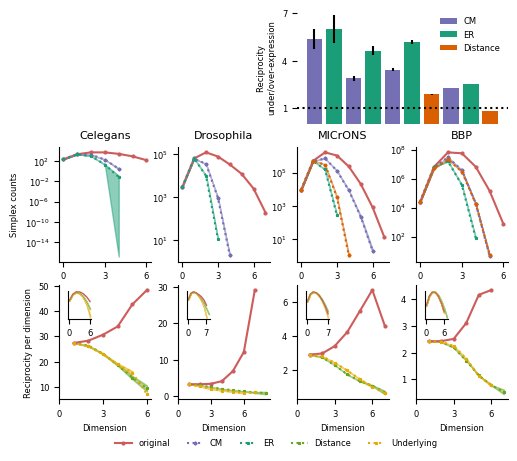

In [6]:
# OPTION 1- log
width=21*0.7/conversion
mosaic = [['.', '.', 'rc_den','rc_den'],
            ['sc_a', 'sc_b','sc_c', 'sc_d'],
           ['rc_a', 'rc_b','rc_c', 'rc_d']]
fig, axes =plt.subplot_mosaic(mosaic,figsize=(width, width*3.5/4))

# Reciprocal density
plot_rc_bar(axes['rc_den'], connectomes)
axes['rc_den'].axline((0,1), slope=0, linestyle="dotted", color="black")
axes['rc_den'].set_ylabel("Reciprocity \nunder/over-expression", fontsize=labelsize)

axs=np.array([axes[key] for key in list(axes.keys())[1:]]).reshape(2,4)# For easy handling
for j, conn in enumerate(connectomes): 
    axs[0, j].set_title(conn, fontsize=titlesize)
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.spines[["top", "right"]].set_visible(False)
labels=['original']
for j, conn in enumerate(connectomes): 
    # Simplex counts 
    i=0
    axs[i,0].set_ylabel("Simplex counts", fontsize=labelsize)
    for ctr in sc[conn].keys():
        axs[i,j].set_yscale('log')
        if ctr=='original':
            axs[i,j].plot(sc[conn][ctr], color=colors[ctr], marker=markers[ctr],ms=marker_size)
        elif (ctr!='underlying_model') and (ctr!='bishuffled_model'):
            if conn=='MICrONS': labels+=[legend[ctr]]
            df=pd.DataFrame.from_dict(sc[conn][ctr]).fillna(0).astype(int)
            plot_control(axs[i,j],df,ctr,alpha=0.5, linestyle="dotted", marker=markers[ctr])
        axs[i,j].minorticks_off()

    # Reciprocal connections
    i=1
    axs[i,0].set_ylabel("Reciprocity per dimension", fontsize=labelsize)
    for ctr in rc[conn].keys():
        axs[i,j].set_xlabel('Dimension', fontsize=labelsize)
        if ctr=='original':
            axs[i,j].plot(rc[conn][ctr].index, rc[conn][ctr]['rc/edges_percent'],
                          marker=markers[ctr],ms=marker_size, color=colors[ctr])
        else:
            if conn=='MICrONS': labels+=[legend[ctr]]
            df=pd.DataFrame.from_dict({key:rc[conn][ctr][key]['rc/edges_percent'] for key in rc[conn][ctr]})
            plot_control(axs[i,j],df, ctr, alpha=0.5, linestyle="dotted", marker=markers[ctr])
    x0, y0, width, height=0.1, 0.7, 0.25, 0.25
    ax=axs[i,j].inset_axes([x0, y0, width, height])
    plot_sc_inset(ax, conn)


        
# Adding legend
# Get lines 
h1=axs[0,1].get_lines(); h2=axs[1,1].get_lines()[1:]
fig.legend(handles=h1+h2, labels=labels, frameon=False, ncols=6, loc=8, bbox_to_anchor=(0.5,0),fontsize=labelsize)

# Fixing tickmark 
for ax in axs.flatten():
    ax.set_xticks([0,3,6])
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.yaxis.get_offset_text().set_fontsize(ticksize)

plt.subplots_adjust(wspace=.3)


fig.savefig("figs/basic_props_opt1_log.pdf", transparent=True, bbox_inches='tight')

Warning!!! When accessing the adjacency as a sparse matrix using the .matrix property:
    Connections that are not present at a given stage, but at other stages will be represented as edges,
    but with a value of ``0`` synapses associated with them.  For structural analysis always use .eliminate_zeros


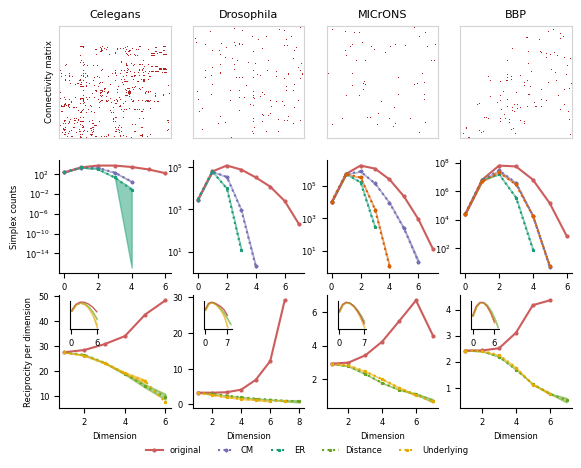

In [7]:
# OPTION 2
width=21*0.8/conversion
rows=3; cols=4
fig, axs = plt.subplots(rows,cols,figsize=(width, width*rows/(cols)))
for j, conn in enumerate(connectomes): 
    axs[0, j].set_title(conn, fontsize=titlesize)
for ax in axs[1:,:].flatten():
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.spines[["top", "right"]].set_visible(False)

labels=['original']
for j, conn in enumerate(connectomes): 
    # Connectomes 
    i=0
    axs[i,0].set_ylabel("Connectivity matrix", fontsize=labelsize)
    adj=load_connectome('../../data', conn).matrix.astype(bool).toarray()
    plot_binary_matrix(adj,'firebrick',axs[i,j])
    del(adj)
    # Simplex counts 
    i=1
    axs[i,0].set_ylabel("Simplex counts", fontsize=labelsize)
    for ctr in sc[conn].keys():
        axs[i,j].set_yscale('log')
        if ctr=='original':
            axs[i,j].plot(sc[conn][ctr], color=colors[ctr], marker=markers[ctr],ms=marker_size)
        elif (ctr!='underlying_model') and (ctr!='bishuffled_model'):
            if conn=='MICrONS': labels+=[legend[ctr]]
            df=pd.DataFrame.from_dict(sc[conn][ctr]).fillna(0).astype(int)
            plot_control(axs[i,j],df,ctr,alpha=0.5, linestyle="dotted", marker=markers[ctr])
        axs[i,j].minorticks_off()

    # Reciprocal connections
    i=2
    axs[i,0].set_ylabel("Reciprocity per dimension", fontsize=labelsize)
    for ctr in rc[conn].keys():
        axs[i,j].set_xlabel('Dimension', fontsize=labelsize)
        if ctr=='original':
            axs[i,j].plot(rc[conn][ctr].index, rc[conn][ctr]['rc/edges_percent'],
                          marker=markers[ctr],ms=marker_size, color=colors[ctr])
        else:
            if conn=='MICrONS': labels+=[legend[ctr]]
            df=pd.DataFrame.from_dict({key:rc[conn][ctr][key]['rc/edges_percent'] for key in rc[conn][ctr]})
            plot_control(axs[i,j],df, ctr, alpha=0.5, linestyle="dotted", marker=markers[ctr])
    x0, y0, width, height=0.1, 0.7, 0.25, 0.25
    ax=axs[i,j].inset_axes([x0, y0, width, height])
    plot_sc_inset(ax, conn)


        
# Adding legend
# Get lines 
h1=axs[1,1].get_lines(); h2=axs[2,1].get_lines()[1:]
fig.legend(handles=h1+h2, labels=labels, frameon=False, ncols=6, loc=8, bbox_to_anchor=(0.5,0),fontsize=labelsize)
fig.savefig("figs/basic_props_opt2.pdf", transparent=True, bbox_inches='tight')

# Stats and counts 

In [8]:
# Edges missing in CM models
edges={}
for conn in connectomes:
    edges[conn]={}
    temp=pd.DataFrame.from_dict(sc[conn]["configuration_model"]).fillna(0).astype(float).loc[1]
    edges[conn]["original"], edges[conn]["mean"], edges[conn]["sem"] = (sc[conn]["original"].loc[1], temp.mean(), stats.sem(temp))
edges=pd.DataFrame.from_dict(edges).T
edges["percent_lost"]=(edges["original"]-edges["mean"])*100/edges["original"]
edges

,original,mean,sem,percent_lost
Celegans,2186.0,2.076800e+03,1.529330,4.995425
Drosophila,63518.0,6.282253e+04,4.546499,1.094913
MICrONS,520477.0,5.144778e+05,11.223506,1.152641
BBP,6717001.0,6.658248e+06,41.934457,0.874690


In [9]:
# Simple counts --> We should do this with more samples 
pvalues={}
for conn in connectomes:
    pvalues[conn]={}
    for ctr in sc[conn].keys():
        ori=sc[conn]["original"]
        if ctr not in ["original", "underlying_model", "bishuffled_model"]:
            pvalues[conn][ctr]={}
            temp=pd.DataFrame.from_dict(sc[conn][ctr]).fillna(0).astype(float)
            for dim in temp.index[2:]:
                pvalues[conn][ctr][dim]=stats.ttest_1samp(temp.loc[dim], ori.loc[dim], alternative="less").pvalue
    print(f"\n\nFor {conn} the maximum p-value of the 1-sided t-test is {np.nanmax(pd.DataFrame.from_dict(pvalues[conn]))}")

  



For Celegans the maximum p-value of the 1-sided t-test is 5.7939232549884e-55


For Drosophila the maximum p-value of the 1-sided t-test is 5.154502089711336e-78


For MICrONS the maximum p-value of the 1-sided t-test is 4.688434507976739e-65


For BBP the maximum p-value of the 1-sided t-test is 1.9882840760296867e-93


In [10]:
# Reciprocal density
pvalues={}
for conn in connectomes:
    pvalues[conn]={}
    for ctr in sc[conn].keys():
        if ctr not in ["original", "underlying_model", "bishuffled_model"]:
            pvalues[conn][ctr]=stats.ttest_1samp(pd.DataFrame.from_dict(rc_den[conn][ctr]).fillna(0).astype(float),rc_den[conn]["original"], 
                  alternative="two-sided").pvalue[0]
pvalues=pd.DataFrame.from_dict(pvalues)            
print("Results of two sided t-test for reciprocal connections")
display(pvalues)
print(f"Maximum p-value attained {np.nanmax(pvalues)}")

Results of two sided t-test for reciprocal connections


,Celegans,Drosophila,MICrONS,BBP
configuration_model,2.959296e-157,1.963887e-157,3.865679e-204,2.141606e-236
ER_shuffle,2.900526e-155,1.949877e-176,1.537722e-222,6.662921e-247
run_DD2,NaN,NaN,1.238706e-181,8.220454e-163


Maximum p-value attained 2.900525977434819e-155
